# Extract CCD VisitTables  in  OGA in tract 3864


and Save Extracted Visits into a pandas dataframe file

 work with Weakly_2024_07
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2024/03/05
- update : 2024/03/05

In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2024_07/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2024_07/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2024_07/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+34187316c4 	current w_2024_07 setup


In [3]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

In [8]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None



## Configuration

In [9]:
#filevisit_out="ccdVisitTable_202312.csv"
filevisit_out="ccdVisitTable_202402.csv"
#filetractpatch_out = 'Latiss_tractspatchs_202312.pickle'

In [10]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

In [11]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [12]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 

In [13]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    assert RAMIN < RAMAX
    assert DECMIN < DECMAX

    flag = (ra >= RAMIN) and (ra<=RAMAX) and (dec>= DECMIN) and (dec <= DECMAX) 
    return flag

In [14]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
    tractsId_list = list(tracts_patchs_dict.keys())   
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            wcs = tractsInfoWCS_dict[tractID]
            tractInfo = tractsInfo_dict[tractID] 
            patches_selected = list(tracts_patchs_dict[tractID])
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        

## Give the collection

In [15]:
#my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"

In [16]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

## Config

In [17]:
#Auxtel2023_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [18]:
Auxtel2023_tracts = [382,383,452,455,
                     3863,3864,
                     5614,5615,5616,5634,5839,
                     #8188,
                     10643,10644]

In [19]:
with open('../data/202402/Latiss_tractspatchs_202402.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [20]:
tracts_patchs_dict

{10644: array([189, 183, 184, 164, 185, 203, 201, 207, 182, 162, 166, 165, 181,
        161, 188, 208, 180, 202]),
 5634: array([ 90, 110,  71, 112,  73, 109,  93,  92,  91,  53,  72,  55,  52,
        111,  54,  74]),
 3863: array([223, 261, 241, 242, 262, 260, 243, 222, 224]),
 452: array([41, 62, 22, 25, 23, 44, 42, 63, 43, 24]),
 5614: array([250, 251, 230, 210, 212, 232, 211, 213, 249, 229, 231]),
 5616: array([355, 358, 316, 338, 356, 336, 357, 337, 317, 335, 315, 334]),
 5615: array([274, 331, 312, 332, 294, 295, 293, 313, 333, 314, 275, 276]),
 5839: array([9, 8, 7]),
 10643: array([190, 171]),
 455: array([51, 52, 15, 33, 14, 53, 34, 13, 32]),
 382: array([343, 344, 342]),
 3864: array([274, 238, 217, 218, 273, 255, 235, 275, 237, 257, 219, 236, 256,
        254, 276, 216]),
 383: array([359, 360])}

In [21]:
#tract_selected = 5615
#patches_selected = [294,313]
#suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]} and {patches_selected[1]}"

### Find tract

In [22]:
#for tractInfo in skymap:
#    tractID = tractInfo.getId()
#    if tractID == tract_selected:
#        break

In [23]:
#tractInfo

In [24]:
# WCS for this patch
#tWCS=tractInfo.getWcs()

### Find Tract

In [25]:
tractsInfo_dict = {}
tractsInfoWCS_dict = {}
tractsId_list = list(tracts_patchs_dict.keys())

# loop to select the good tracts
for tractInfo in skymap:
    tractID = tractInfo.getId()
    # is this tract in Auxtel tract list
    if tractID in tractsId_list:
        # keep tractInfo
        tractsInfo_dict[tractID] = tractInfo 
        # keep WCS
        tractsInfoWCS_dict[tractID] = tractInfo.getWcs()

### Find patches

In [26]:
#all_patches = []
#for patch in tractInfo:
#    patchID = patch.getSequentialIndex()
#    if patchID in patches_selected:
#        all_patches.append(patch)        

In [27]:
#all_patches

In [28]:
#for patch in all_patches:
#    patchID = patch.getSequentialIndex()
#    ibb=patch.getInnerBBox()
#    print("patch ",patchID,"ibb=",ibb)
#    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(tWCS, ibb)

# Sources

In [29]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=my_collection, where= "instrument='LATISS'")

In [30]:
for i, ref in enumerate(datasetRefs):
   
    print("========================datasetType = ccdVisitTable ============================================")
    print("fullId..................:",ref.dataId.full)
    

========================datasetType = ccdVisitTable ============================================
fullId..................: {instrument: 'LATISS'}


/tmp/ipykernel_14228/4284467752.py:4: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)


In [31]:
visit_table = butler.get('visitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
visit_table

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
2023051100262,2023051100262,SDSSr_65mm~empty,r,239.941279,-24.050861,-24.050861,322.911701,100.652699,33.079204,56.920796,1.826588,30.0,2023-05-12 01:08:56.302993,60076.047874,2023-05-12 01:08:41.302993,60076.047700
2023051100263,2023051100263,SDSSg_65mm~empty,g,239.943099,-24.042851,-24.042851,170.005077,100.427273,33.535722,56.464278,1.804276,30.0,2023-05-12 01:11:06.209005,60076.049377,2023-05-12 01:10:51.209005,60076.049204
2023051100264,2023051100264,SDSSi_65mm~empty,i,239.940919,-24.040927,-24.040927,170.004955,100.024337,34.385246,55.614754,1.765315,30.0,2023-05-12 01:15:04.912000,60076.052140,2023-05-12 01:14:49.912000,60076.051967
2023051100268,2023051100268,SDSSr_65mm~empty,r,239.960079,-24.042010,-24.042010,323.867206,99.573769,35.343223,54.656777,1.724092,30.0,2023-05-12 01:19:39.311494,60076.055316,2023-05-12 01:19:24.311494,60076.055142
2023051100270,2023051100270,SDSSi_65mm~empty,i,239.963850,-24.048746,-24.048746,170.004124,99.285576,35.972240,54.027760,1.697680,30.0,2023-05-12 01:22:36.150002,60076.057363,2023-05-12 01:22:21.150002,60076.057189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024013000166,2024013000166,empty~SDSSy_65mm,y,122.430675,-36.166952,-36.166952,359.999822,179.282384,84.007088,5.992912,1.005412,30.0,2024-01-31 04:14:35.805994,60340.176803,2024-01-31 04:14:20.805994,60340.176630
2024013000167,2024013000167,SDSSg_65mm~empty,g,122.522258,-36.166820,-36.166820,0.000666,181.381738,84.005682,5.994318,1.005414,30.0,2024-01-31 04:16:02.589490,60340.177808,2024-01-31 04:15:47.589490,60340.177634
2024013000168,2024013000168,SDSSr_65mm~empty,r,122.522270,-36.166956,-36.166956,0.000540,182.895972,83.999215,6.000785,1.005425,30.0,2024-01-31 04:16:49.368995,60340.178349,2024-01-31 04:16:34.368995,60340.178176


In [32]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941334,-24.038378,56.289413,27.925329,7.783146,3.989901,7.472743,0.024001,0.011537,17,0.020877,0.003123,0.037679,0.028327,0.131853,0.174565,0.021897,5.176466,2552.229980,0.905713,0.016508,7.518984,0.243232,-24.038378,0,1.754283,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988739,-23.976095,239.872244,-23.996199,239.893884,-24.100647,240.010470,-24.080526
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.837013,6.324102,28.071854,8.586543,0.026761,0.017073,39,0.007049,-0.012680,0.025506,0.043905,0.010775,0.095402,0.015088,0.304010,1387.484985,0.165707,0.025004,1.068686,0.206713,-24.036848,0,1.425322,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.765863,8.100543,10.701077,7.854048,0.024562,0.014017,32,-0.001813,-0.007225,0.012738,0.015732,0.153432,0.113233,0.013615,0.492057,2023.047119,0.232399,0.015240,2.803456,0.181321,-24.045512,0,1.825525,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.847099,6.745777,23.952093,8.440446,0.023946,0.012757,33,-0.011323,0.002748,0.035845,0.022814,-0.030170,0.125044,0.018293,1.152671,1726.039673,0.173889,0.021975,1.252500,0.210590,-24.046364,0,1.520381,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43134264832,2024013000166,empty~SDSSy_65mm,y,122.428828,-36.166063,5.993765,26.073267,4.577834,14.221478,8.110322,0.012466,0.007235,67,0.005375,-0.003194,0.033592,0.025067,-0.021962,0.087823,0.019033,0.437758,1227.355591,0.024230,0.047718,2.109485,0.008024,-36.166063,0,1.031667,359.999822,2024-01-31 04:14:35.805994,60340.176803,30.0,2024-01-31 04:14:20.805994,60340.176630,30.2326,4071,3999,122.362606,-36.219921,122.496767,-36.218499,122.494959,-36.112169,122.360980,-36.113589
43134265088,2024013000167,SDSSg_65mm~empty,g,122.520273,-36.165952,6.002423,28.069672,4.562790,11.795321,7.969728,0.010483,0.004879,109,-0.001298,-0.013367,0.033533,0.024191,-0.014490,0.086460,0.019074,0.699273,908.760864,1.162963,0.048033,2.543381,0.317318,-36.165952,0,1.028190,0.000666,2024-01-31 04:16:02.5894

### Compute night obs

In [33]:
ccd_visit_table["nightObs"] =ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)

### Compute datetime to plot vs time

In [34]:
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

#### Compute airmass

In [35]:
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

### Find those visits in the selected tract and patches

In [36]:
ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [37]:
ccd_visit_table.head()

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941334,-24.038378,56.289413,27.925329,7.783146,3.989901,7.472743,0.024001,0.011537,17,0.020877,0.003123,0.037679,0.028327,0.131853,0.174565,0.021897,5.176466,2552.229980,0.905713,0.016508,7.518984,0.243232,-24.038378,0,1.754283,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988739,-23.976095,239.872244,-23.996199,239.893884,-24.100647,240.010470,-24.080526,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.837013,6.324102,28.071854,8.586543,0.026761,0.017073,39,0.007049,-0.012680,0.025506,0.043905,0.010775,0.095402,0.015088,0.304010,1387.484985,0.165707,0.025004,1.068686,0.206713,-24.036848,0,1.425322,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.765863,8.100543,10.701077,7.854048,0.024562,0.014017,32,-0.001813,-0.007225,0.012738,0.015732,0.153432,0.113233,0.013615,0.492057,2023.047119,0.232399,0.015240,2.803456,0.181321,-24.045512,0,1.825525,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.847099,6.745777,23.952093,8.440446,0.023946,0.012757,33,-0.011323,0.002748,0.035845,0.022814,-0.030170,0.125044,0.018293,1.152671,1726.039673,0.173889,0.021975,1.252500,0.210590,-24.046364,0,1.520381,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294


In [38]:
ccd_visit_table.tail()

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
43134264832,2024013000166,empty~SDSSy_65mm,y,122.428828,-36.166063,5.993765,26.073267,4.577834,14.221478,8.110322,0.012466,0.007235,67,0.005375,-0.003194,0.033592,0.025067,-0.021962,0.087823,0.019033,0.437758,1227.355591,0.024230,0.047718,2.109485,0.008024,-36.166063,0,1.031667,359.999822,2024-01-31 04:14:35.805994,60340.176803,30.0,2024-01-31 04:14:20.805994,60340.176630,30.2326,4071,3999,122.362606,-36.219921,122.496767,-36.218499,122.494959,-36.112169,122.360980,-36.113589,20240130,2024-01-31 04:14:20.805994,1.005497,3864,237
43134265088,2024013000167,SDSSg_65mm~empty,g,122.520273,-36.165952,6.002423,28.069672,4.562790,11.795321,7.969728,0.010483,0.004879,109,-0.001298,-0.013367,0.033533,0.024191,-0.014490,0.086460,0.019074,0.699273,908.760864,1.162963,0.048033,2.543381,0.317318,-36.165952,0,1.028190,0.000666,2024-01-31 04:16:02.589490,60340.177808,30.0,2024-01-31 04:15:47.589490,60340.177634,30.2333,4071,3999,122.454059,-36.219803,122.588204,-36.218390,122.586395,-36.112065,122.452432,-36.113476,20240130,2024-01-31 04:15:47.589490,1.005513,3864,236
43134265344,2024013000168,SDSSr_65mm~empty,r,122.520391,-36.165943,6.013887,27.856039,4.841956,9.200282,7.873821,0.013488,0.006209,121,0.002316,0.003846,0.033141,0.024356,-0.008863,0.054340,0.011123,0.568077,607.322266,0.893283,0.042654,3.260770,0.214087,-36.165943,0,1.091082,0.000540,2024-01-31 04:16:49.368995,60340.178349,30.0,2024-01-31 04:16:34.368995,60340.178176,30.2265,4071,3999,122.454177,-36.219793,122.588325,-36.218377,122.586515,-36.112057,122.452549,-36.113472,20240130,2024-01-31 04:16:34.368995,1.005534,3864,236
43134265600,2024013000169,SDSSz_65mm~empty,z,122.520373,-36.165951,6.028749,27.324080,5.360331,16.084967,8.187736,0.010447,0.005809,27,0.001900,0.000604,0.031006,0.015473,-0.011240,0.061504,0.010587,0.815424,3160.135742,0.156481,0.034803,1.865096,0.080357,-36.165951,0,1.207755,359.999892,2024-01-31 04:17:33.466999,60340.178860,30.0,2024-01-31 04:17:18.466999,60340.178686,30.2680,4071,3999,122.454163,-36.219791,122.588306,-36.218373,122.586491,-36.112074,122.452530,-36.113490,20240130,2024-01-31 04:17:18.466999,1.005561,3864,236
43134265856,2024013000170,empty~SDSSy_65mm,y,122.520784,-36.165975,6.049546,26.214890,8.200642,14.658229,8.150498,0.019129,0.011223,44,-0.055608,0.024479,0.017686,0.017519,0.750685,0.141419,0.014587,0.411785,971.511536,0.009509,0.014870,2.046632,0.010415,-36.165975,0,1.848087,0.000237,2024-01-31 04:18:21.970002,60340.179421,30.0,2024-01-31 04:18:06.970002,60340.179247,30.2305,4071,3999,122.454565,-36.219824,122.588725,-36.218418,122.586912,-36.112089,122.452934,-36.113493,20240130,2024-01-31 04:18:06.970002,1.005600,3864,236


## Find those visits in the selected tract and patches

### Patch 236 and 237

In [39]:
tract_selected = 3864
patch_selected = 236

suptitle = f"CCD visit in tract {tract_selected} and patch {patch_selected}"

In [40]:
ccd_visit_table1 = ccd_visit_table
ccd_visit_table1["selectedFlag"] = ccd_visit_table1[["tractID","patchID"]].apply(lambda x: x[0] == tract_selected and x[1] == patch_selected,axis =1, raw= True )

In [41]:
ccd_visit_table_selected1 = ccd_visit_table1[ccd_visit_table1["selectedFlag"]]

In [42]:
ccd_visit_table_selected1.drop(["selectedFlag"],axis=1,inplace=True) 

/tmp/ipykernel_14228/4130735938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected1.drop(["selectedFlag"],axis=1,inplace=True)


In [43]:
ccd_visit_table_selected1.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'effTime',
       'effTimePsfSigmaScale', 'effTimeSkyBgScale', 'effTimeZeroPointScale',
       'decl', 'detector', 'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD',
       'expTime', 'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize',
       'llcra', 'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra',
       'lrcdec', 'nightObs', 'Time', 'airmass', 'tractID', 'patchID'],
      dtype='object')

In [44]:
df = ccd_visit_table_selected1

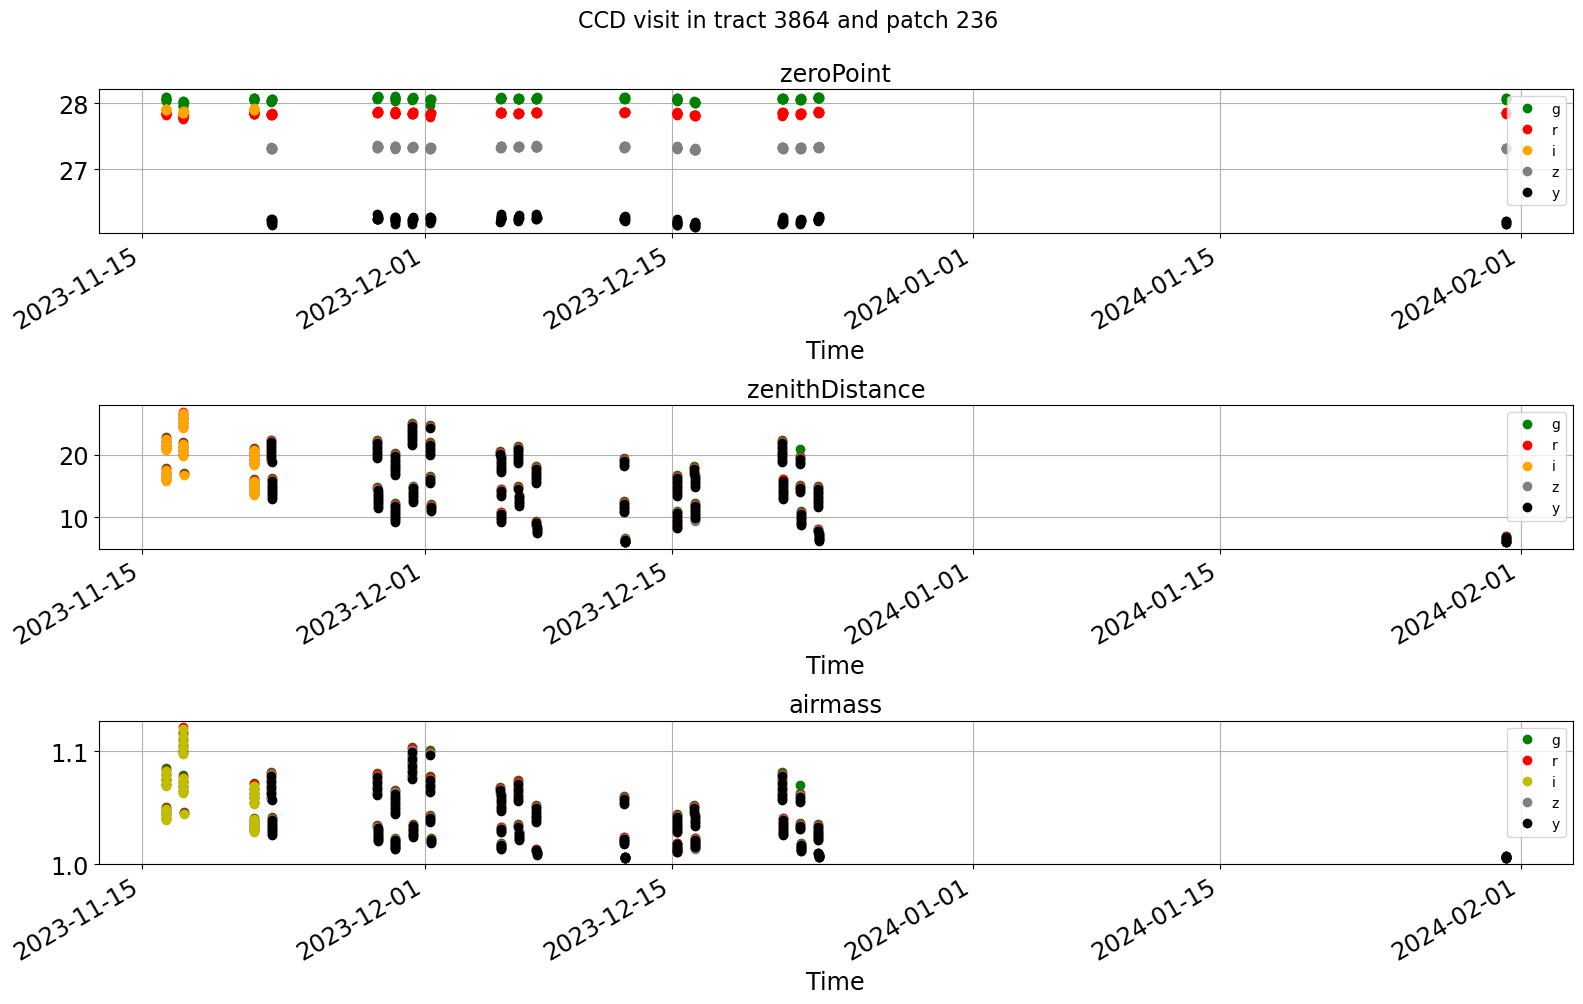

In [45]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,label="g")
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,label="r")
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
df[df["band"]=="z"].plot(x="Time",y="zeroPoint",marker='o',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
df[df["band"]=="y"].plot(x="Time",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_title("zeroPoint")


df[df["band"]=="g"].plot(x="Time",y="zenithDistance",marker='o',c="g",lw=0.0,ax=ax2,grid=True,label="g")
df[df["band"]=="r"].plot(x="Time",y="zenithDistance",marker='o',c="r",lw=0.0,ax=ax2,grid=True,label="r")
df[df["band"]=="i"].plot(x="Time",y="zenithDistance",marker='o',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
df[df["band"]=="z"].plot(x="Time",y="zenithDistance",marker='o',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
df[df["band"]=="y"].plot(x="Time",y="zenithDistance",marker='o',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_title("zenithDistance")

df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax3,grid=True,label="g")
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax3,grid=True,label="r")
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax3,grid=True,label="i")
df[df["band"]=="z"].plot(x="Time",y="airmass",marker='o',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
df[df["band"]=="y"].plot(x="Time",y="airmass",marker='o',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_title("airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Plot number of visit per day

### Plot number of visit per day for patch 236

In [46]:
ccd_visit_table1["dayobsMJD"]=ccd_visit_table1["obsStartMJD"].apply(np.int64)

In [47]:
ccd_visit_table1.sort_values(by=['nightObs',"obsStartMJD"])

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,tractID,patchID,selectedFlag,dayobsMJD
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295,False,60076
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941334,-24.038378,56.289413,27.925329,7.783146,3.989901,7.472743,0.024001,0.011537,17,0.020877,0.003123,0.037679,0.028327,0.131853,0.174565,0.021897,5.176466,2552.229980,0.905713,0.016508,7.518984,0.243232,-24.038378,0,1.754283,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988739,-23.976095,239.872244,-23.996199,239.893884,-24.100647,240.010470,-24.080526,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295,False,60076
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.837013,6.324102,28.071854,8.586543,0.026761,0.017073,39,0.007049,-0.012680,0.025506,0.043905,0.010775,0.095402,0.015088,0.304010,1387.484985,0.165707,0.025004,1.068686,0.206713,-24.036848,0,1.425322,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295,False,60076
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.765863,8.100543,10.701077,7.854048,0.024562,0.014017,32,-0.001813,-0.007225,0.012738,0.015732,0.153432,0.113233,0.013615,0.492057,2023.047119,0.232399,0.015240,2.803456,0.181321,-24.045512,0,1.825525,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294,False,60076
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.847099,6.745777,23.952093,8.440446,0.023946,0.012757,33,-0.011323,0.002748,0.035845,0.022814,-0.030170,0.125044,0.018293,1.152671,1726.039673,0.173889,0.021975,1.252500,0.210590,-24.046364,0,1.520381,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294,False,60076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43134264832,2024013000166,empty~SDSSy_65mm,y,122.428828,-36.166063,5.993765,26.073267,4.577834,14.221478,8.110322,0.012466,0.007235,67,0.005375,-0.003194,0.033592,0.025067,-0.021962,0.087823,0.019033,0.437758,1227.355591,0.024230,0.047718,2.109485,0.008024,-36.166063,0,1.031667,359.999822,2024-01-31 04:14:35.805994,60340.176803,30.0,2024-01-31 04:14:20.805994,60340.

In [48]:
#ccd_visit_table1.sort_values(by=['dayobsMJD']).count()
ccd_visit_table_counts = ccd_visit_table1.groupby(['nightObs','band']).count()["visitId"]

In [49]:
type(ccd_visit_table_counts)

pandas.core.series.Series

In [50]:
ccd_visit_table_counts.name='counts'
ccd_visit_table_counts

nightObs  band
20230511  g       85
          i       85
          r       87
20230523  g       13
          i       13
                  ..
20240129  z        4
20240130  g       15
          r       15
          y       15
          z       15
Name: counts, Length: 147, dtype: int64

/tmp/ipykernel_14228/553158272.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ccd_visit_table.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


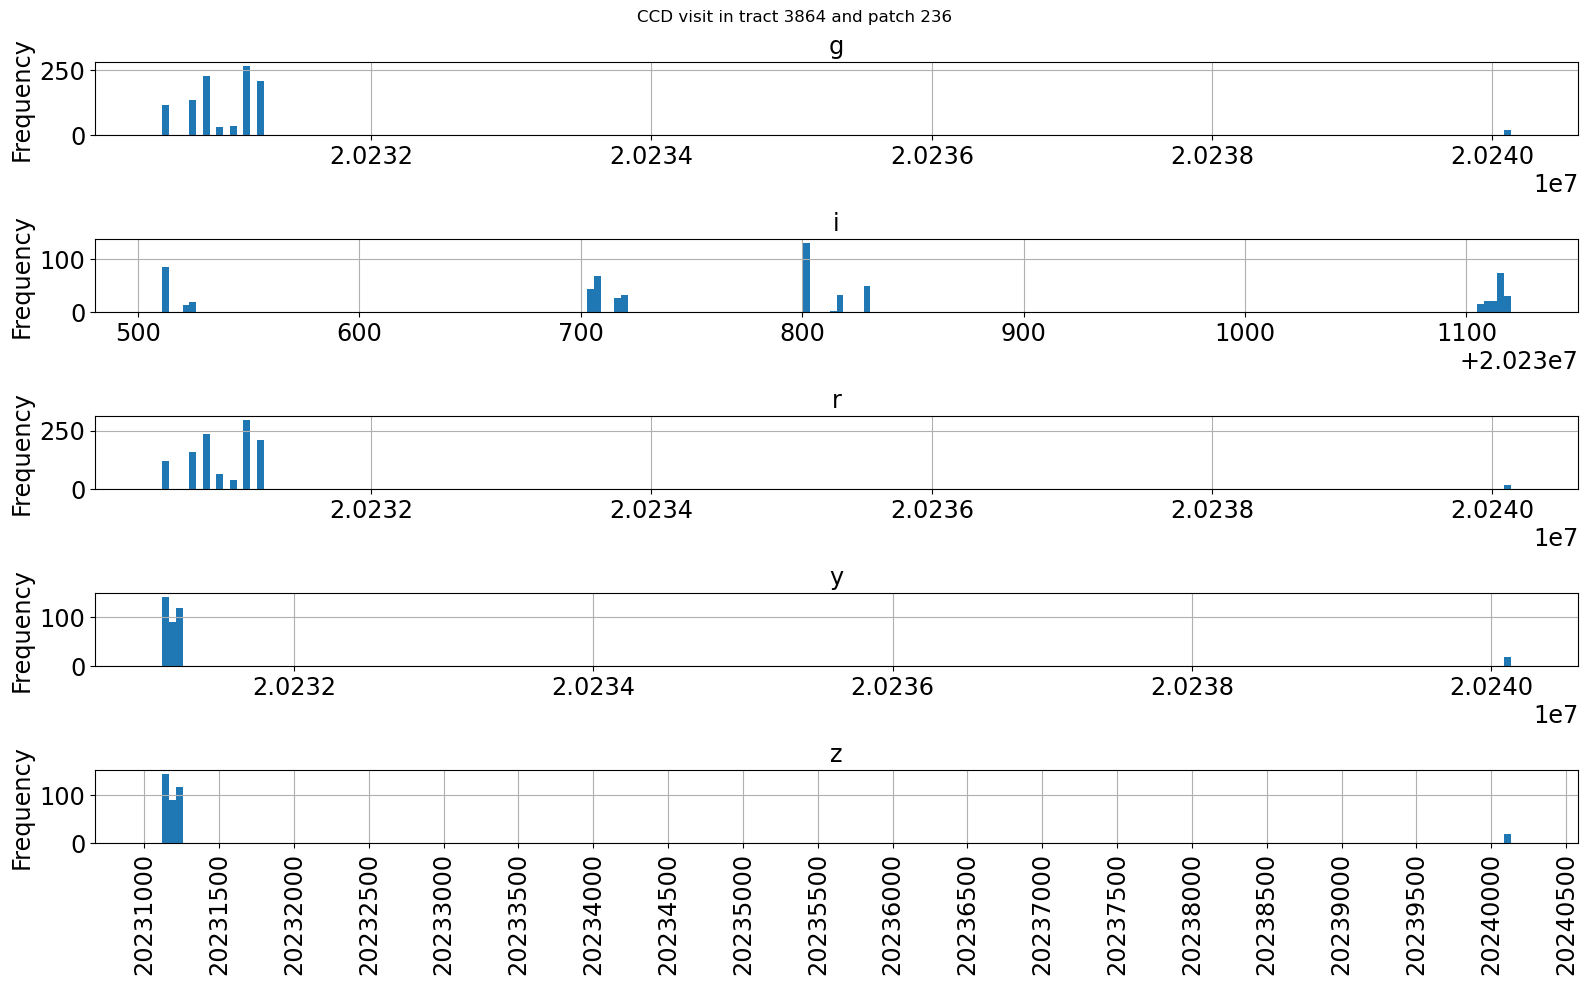

In [51]:
import matplotlib.ticker
fig,ax = plt.subplots(1,1,figsize=(16,10))
ccd_visit_table.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(2)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

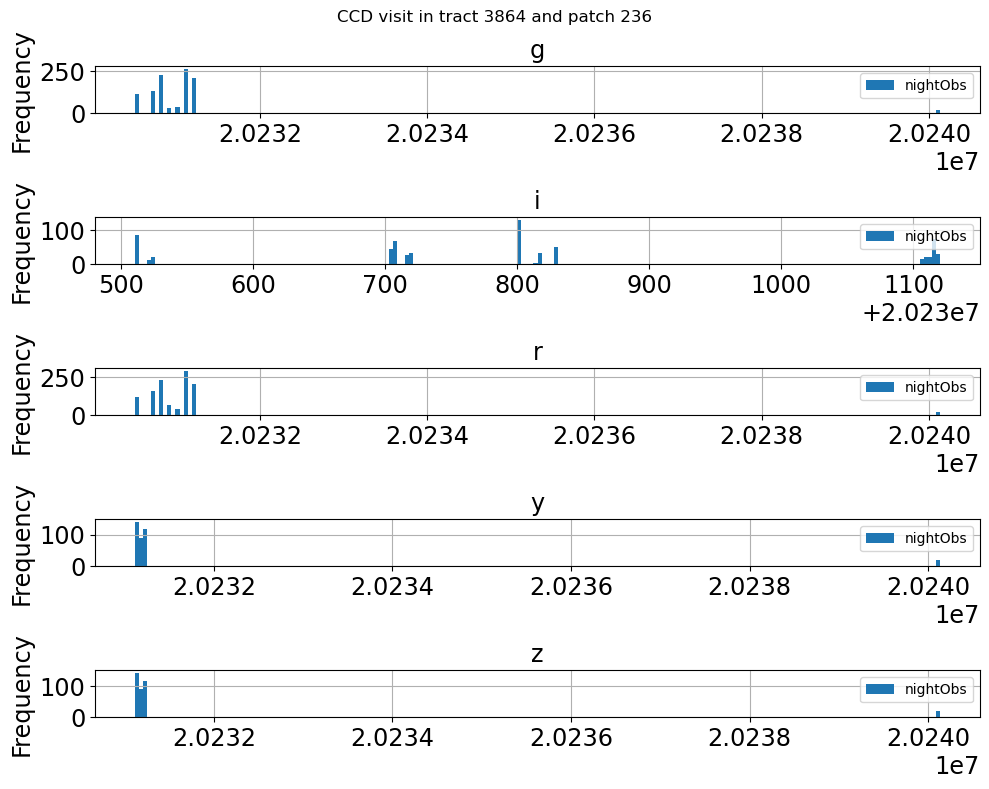

In [52]:
ccd_visit_table1.plot.hist(column=["nightObs"], by="band", bins=200,figsize=(10, 8),grid=True,label=False)
plt.suptitle(suptitle)
plt.tight_layout()


In [53]:
ccd_visit_table_counts1 = ccd_visit_table1.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts1

nightObs  band
20230511  g       85
          i       85
          r       87
20230523  g       13
          i       13
                  ..
20240129  z        4
20240130  g       15
          r       15
          y       15
          z       15
Name: visitId, Length: 147, dtype: int64

#### Select one night and plot Zero point and Airmass

In [54]:
nightObs_selected = 20231121
ccd_visit_table1_sel = ccd_visit_table1[ccd_visit_table1.nightObs == nightObs_selected]

In [55]:
df = ccd_visit_table1_sel

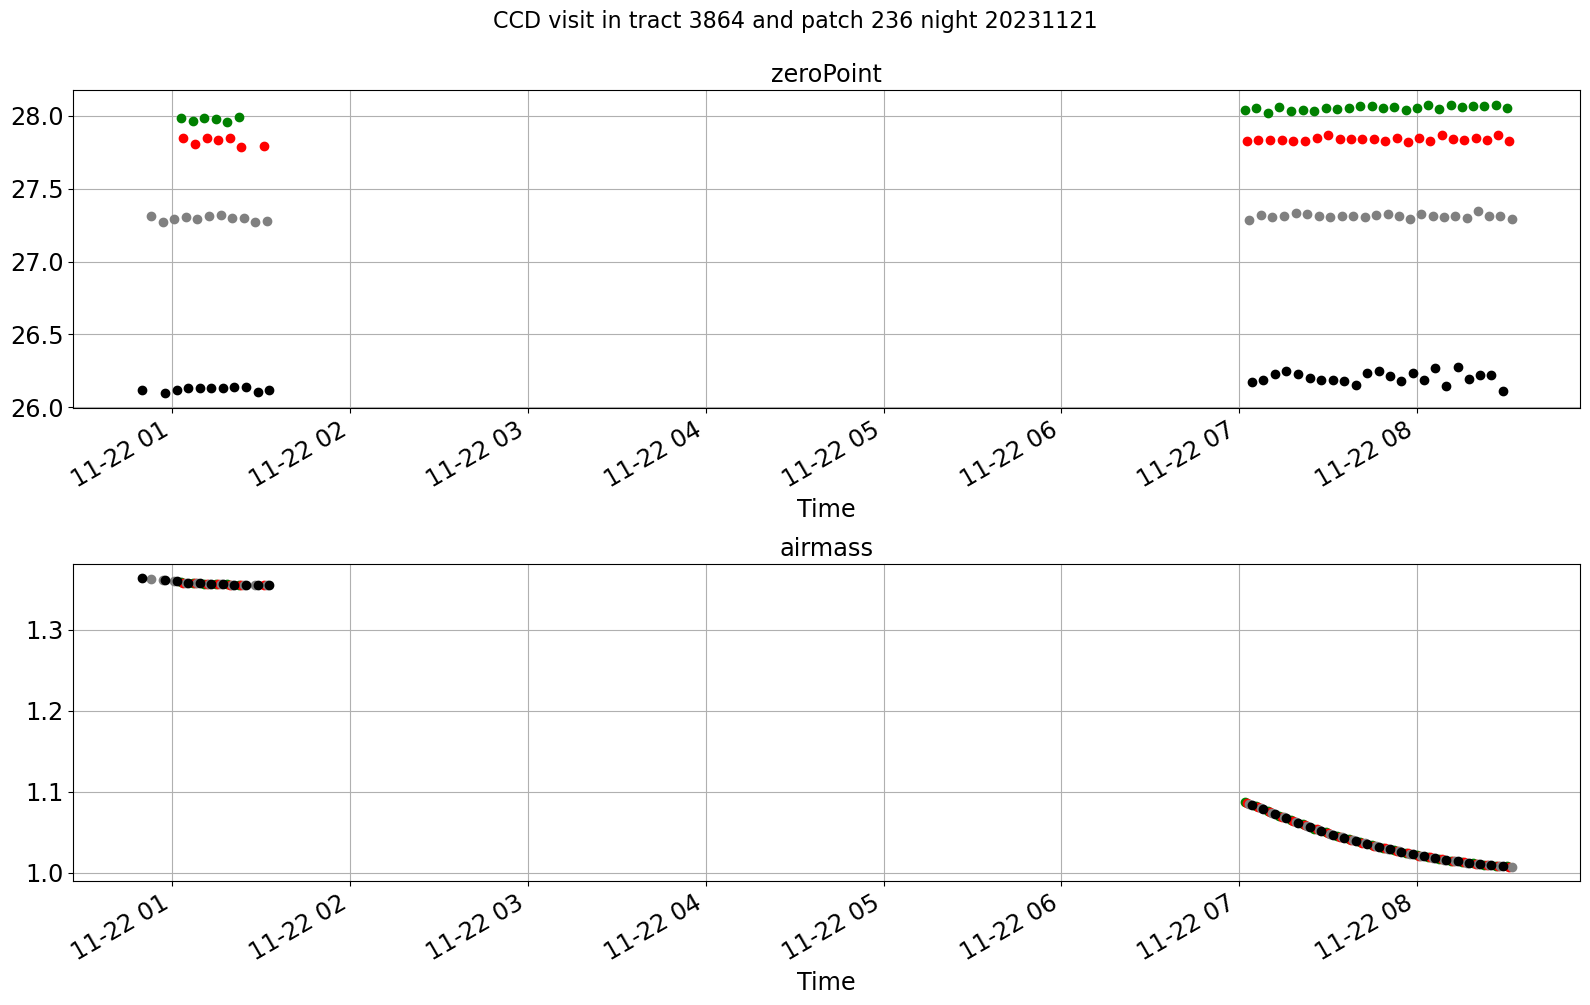

In [56]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="orange",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="z"].plot(x="Time",y="zeroPoint",marker='o',c="grey",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="y"].plot(x="Time",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")

df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="orange",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="z"].plot(x="Time",y="airmass",marker='o',c="grey",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="y"].plot(x="Time",y="airmass",marker='o',c="k",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
plt.tight_layout()

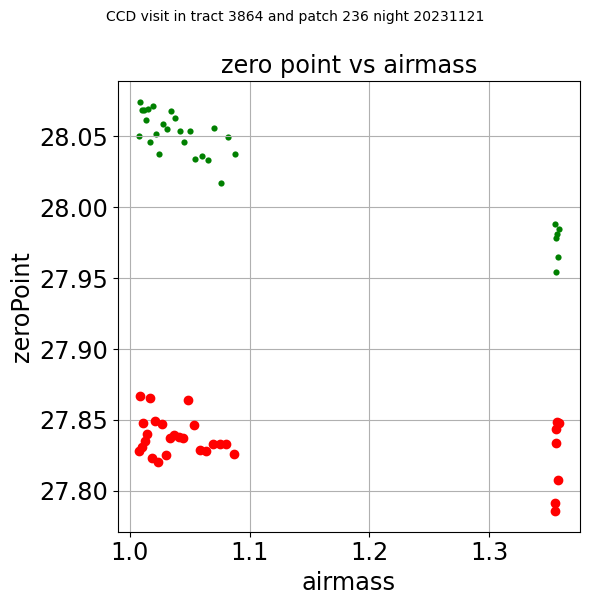

In [57]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

df[df["band"]=="g"].plot.scatter(x="airmass",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="r"].plot(x="airmass",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="i"].plot(x="airmass",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax,grid=True,legend=False)
ax.set_title("zero point vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=10)
plt.tight_layout()

### Plot number of visit per day for patch 237

In [58]:
tract_selected = 3864
patch_selected = 237
suptitle = f"CCD visit in tract {tract_selected} and patch {patch_selected}"

In [59]:
ccd_visit_table2 = ccd_visit_table
ccd_visit_table2["selectedFlag"] = ccd_visit_table2[["tractID","patchID"]].apply(lambda x: x[0] == tract_selected and x[1] == patch_selected,axis =1, raw= True )


In [60]:
ccd_visit_table_selected2 = ccd_visit_table1[ccd_visit_table2["selectedFlag"]]
ccd_visit_table_selected2.drop(["selectedFlag"],axis=1,inplace=True) 

/tmp/ipykernel_14228/617366358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected2.drop(["selectedFlag"],axis=1,inplace=True)


In [61]:
#ccd_visit_table2["dayobsMJD"]=ccd_visit_table2["obsStartMJD"].apply(np.int64)
#ccd_visit_table2['nightObs'] =ccd_visit_table2.apply(lambda x: x['visitId']//100_000, axis=1)

/tmp/ipykernel_14228/3938482959.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ccd_visit_table2.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


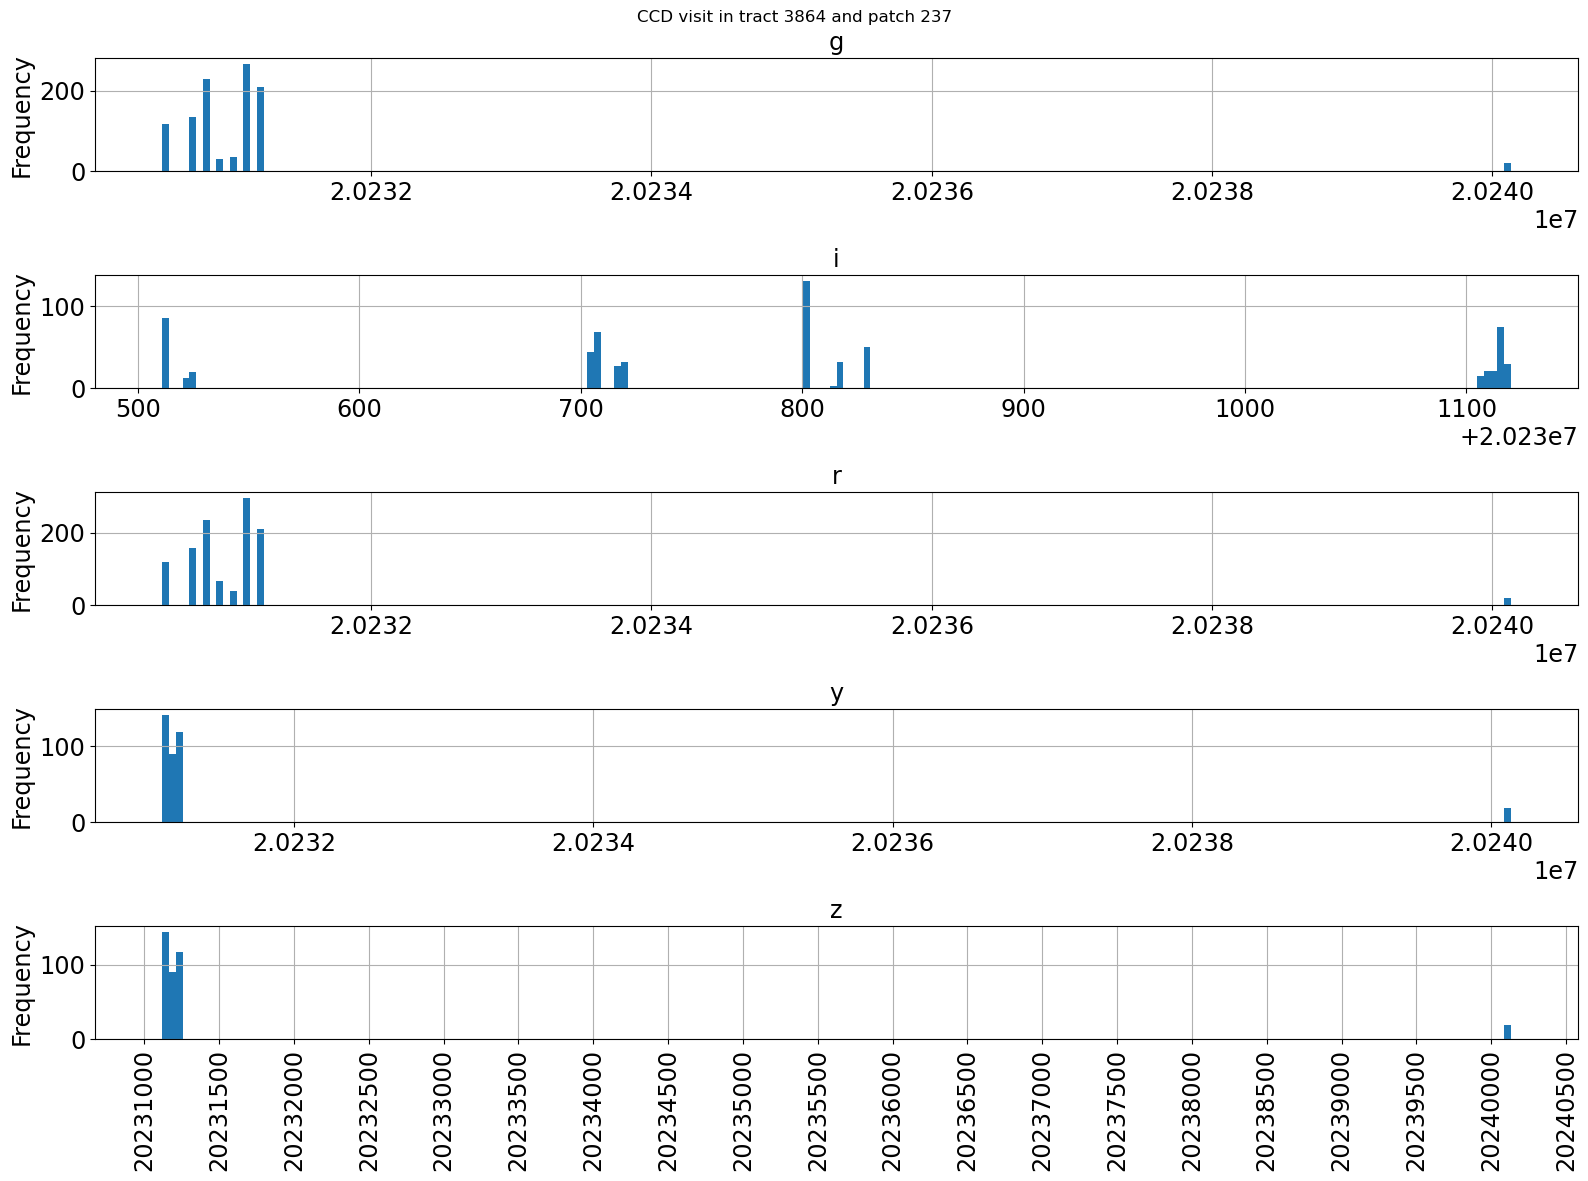

In [62]:
import matplotlib.ticker
fig,ax = plt.subplots(1,1,figsize=(16,12))
ccd_visit_table2.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(2)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

## Select one night

In [63]:
nightObs_selected =  20231121
ccd_visit_table1_sel = ccd_visit_table1[ccd_visit_table1.nightObs == nightObs_selected]
ccd_visit_table2_sel = ccd_visit_table2[ccd_visit_table2.nightObs == nightObs_selected]

In [64]:
tract_selected = 3864
patch_selected = 237
#patch_selected = 313
suptitle = f"CCD visit in tract {tract_selected} and patch {patch_selected}"
df = ccd_visit_table1_sel

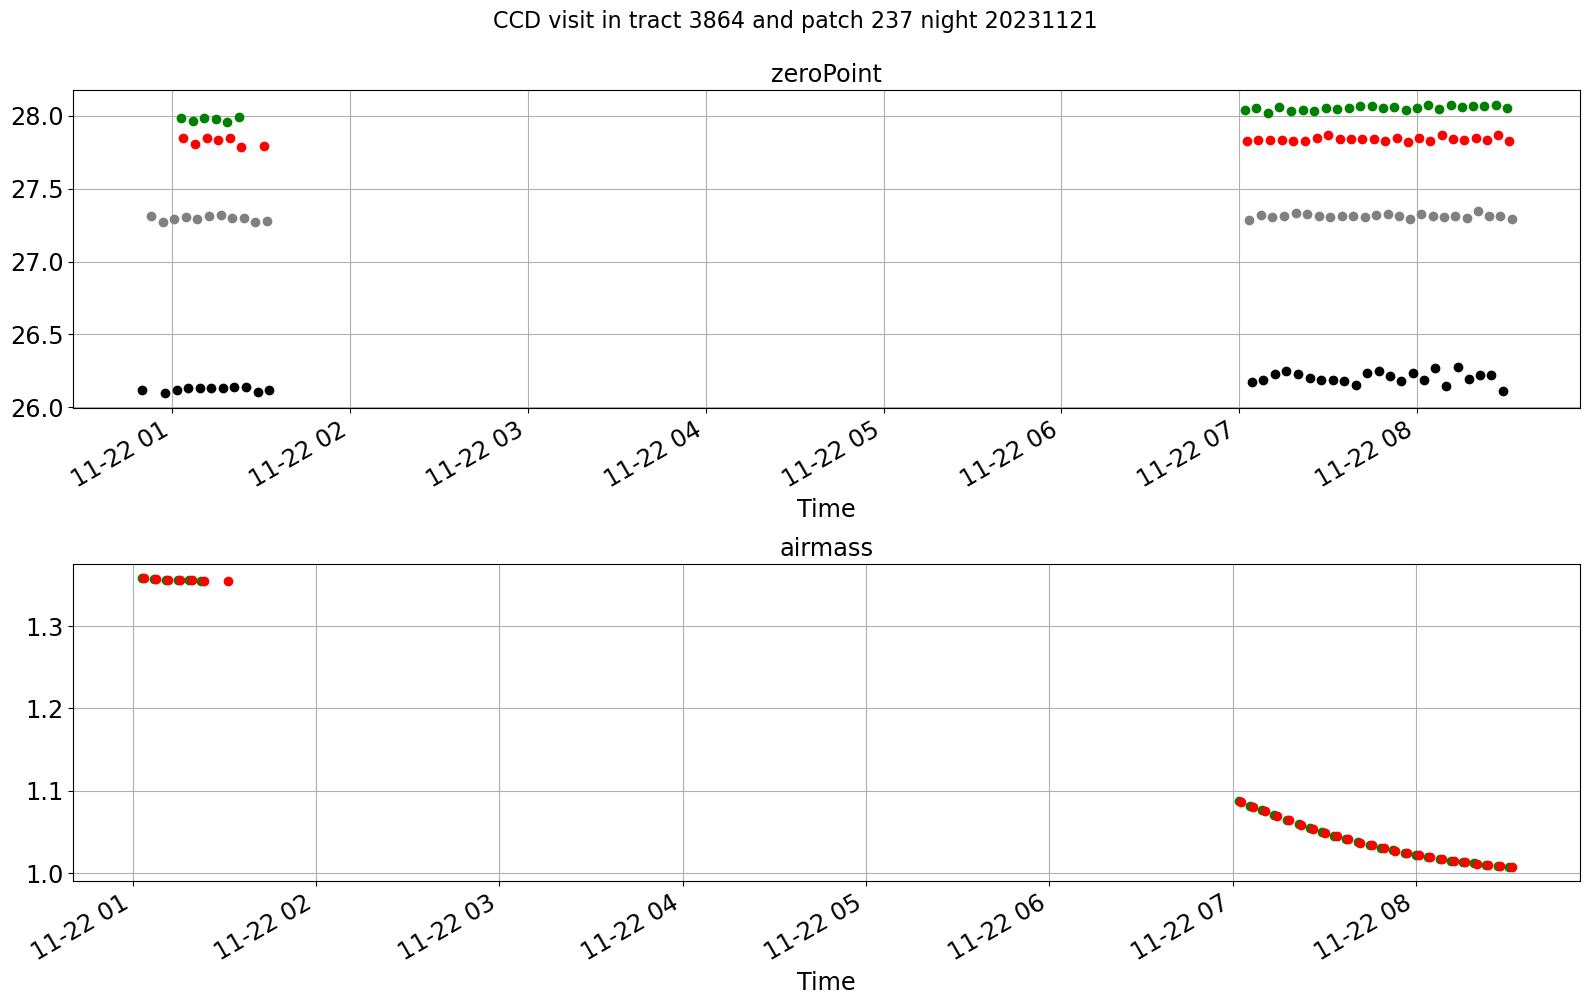

In [65]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="z"].plot(x="Time",y="zeroPoint",marker='o',c="grey",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="y"].plot(x="Time",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")

df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("airmass")


#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
plt.tight_layout()

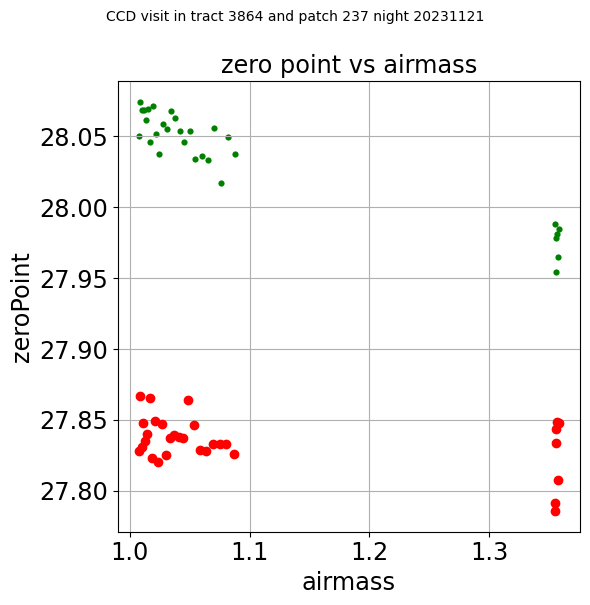

In [66]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

df[df["band"]=="g"].plot.scatter(x="airmass",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="r"].plot(x="airmass",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="i"].plot(x="airmass",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax,grid=True,legend=False)
ax.set_title("zero point vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=10)
plt.tight_layout()

In [67]:
tract_selected = 3864
patch_selected = 237
suptitle = f"CCD visit in tract {tract_selected} and patch {patch_selected}"
df = ccd_visit_table2_sel

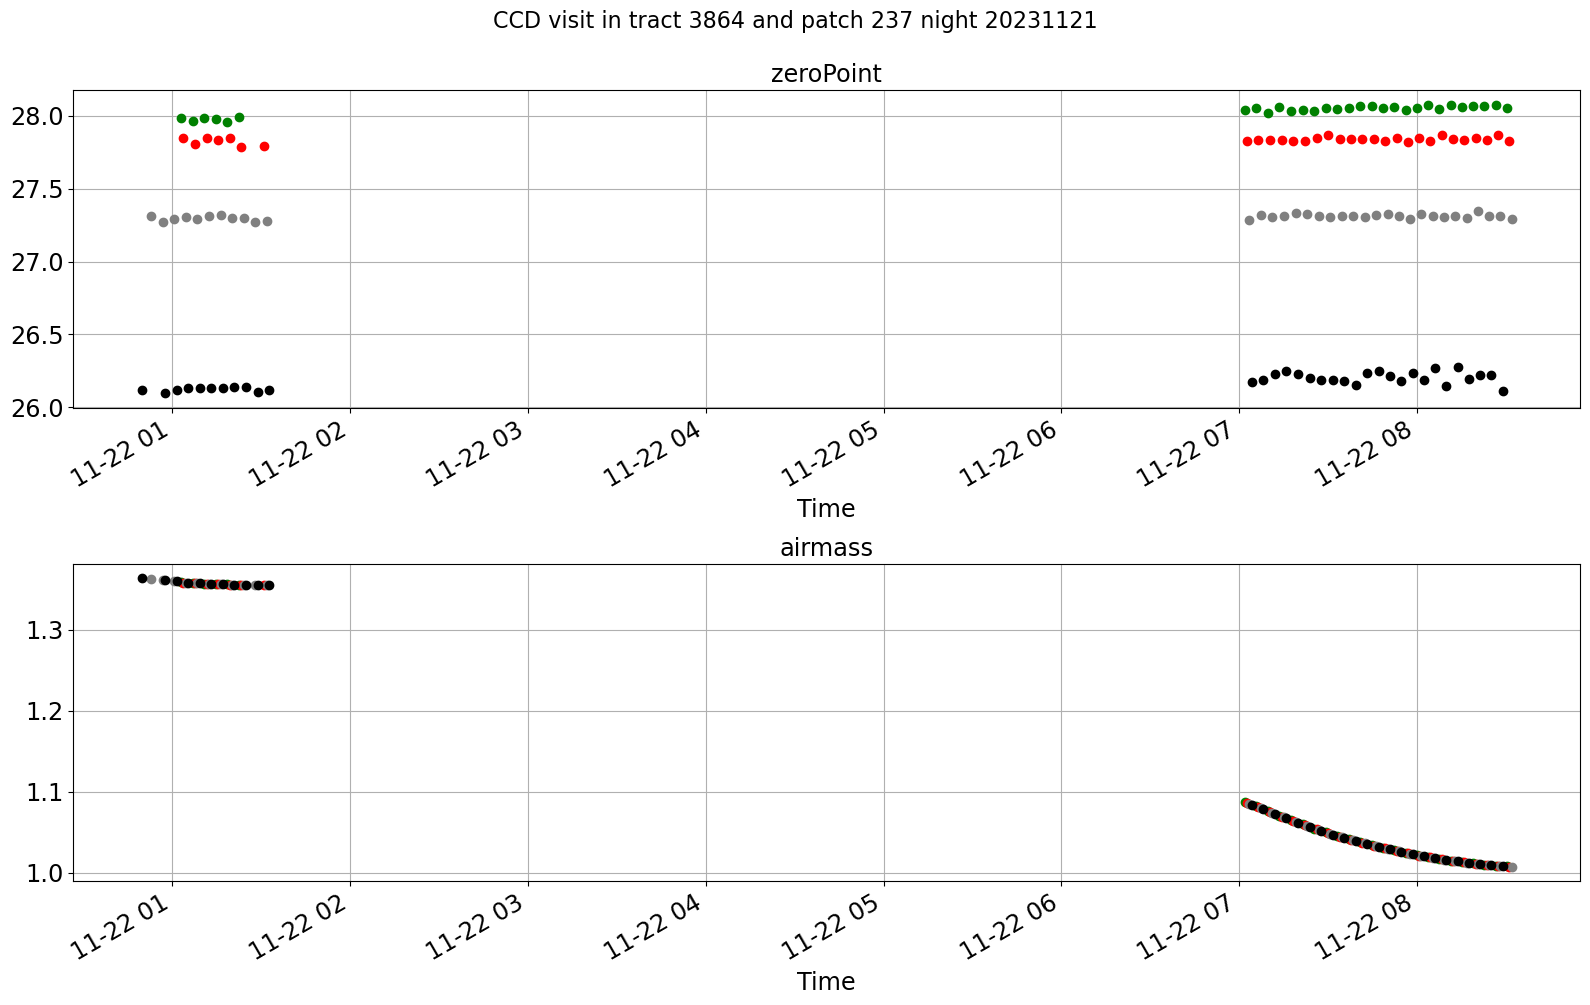

In [68]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="z"].plot(x="Time",y="zeroPoint",marker='o',c="grey",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="y"].plot(x="Time",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")

df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="z"].plot(x="Time",y="airmass",marker='o',c="grey",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="y"].plot(x="Time",y="airmass",marker='o',c="k",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("airmass")


#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
plt.tight_layout()

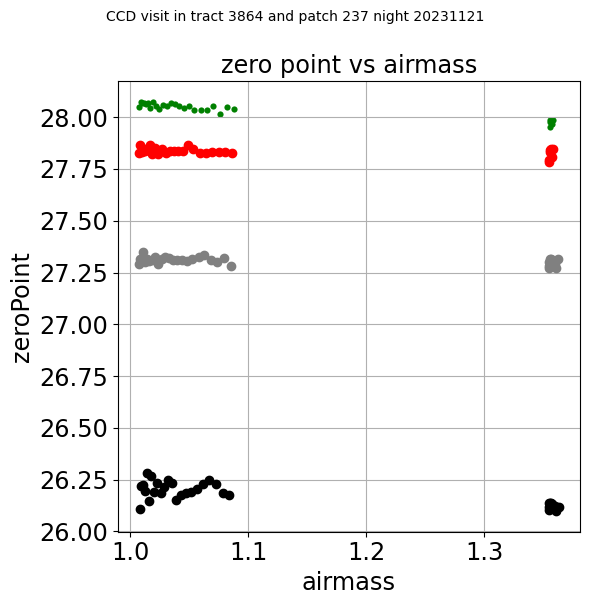

In [69]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

df[df["band"]=="g"].plot.scatter(x="airmass",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="r"].plot(x="airmass",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="i"].plot(x="airmass",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="z"].plot(x="airmass",y="zeroPoint",marker='o',c="grey",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="y"].plot(x="airmass",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax,grid=True,legend=False)
ax.set_title("zero point vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=10)
plt.tight_layout()

# save CCD Visit

In [70]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,tractID,patchID,selectedFlag,dayobsMJD
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295,False,60076
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941334,-24.038378,56.289413,27.925329,7.783146,3.989901,7.472743,0.024001,0.011537,17,0.020877,0.003123,0.037679,0.028327,0.131853,0.174565,0.021897,5.176466,2552.229980,0.905713,0.016508,7.518984,0.243232,-24.038378,0,1.754283,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988739,-23.976095,239.872244,-23.996199,239.893884,-24.100647,240.010470,-24.080526,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295,False,60076
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.837013,6.324102,28.071854,8.586543,0.026761,0.017073,39,0.007049,-0.012680,0.025506,0.043905,0.010775,0.095402,0.015088,0.304010,1387.484985,0.165707,0.025004,1.068686,0.206713,-24.036848,0,1.425322,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295,False,60076
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.765863,8.100543,10.701077,7.854048,0.024562,0.014017,32,-0.001813,-0.007225,0.012738,0.015732,0.153432,0.113233,0.013615,0.492057,2023.047119,0.232399,0.015240,2.803456,0.181321,-24.045512,0,1.825525,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294,False,60076
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.847099,6.745777,23.952093,8.440446,0.023946,0.012757,33,-0.011323,0.002748,0.035845,0.022814,-0.030170,0.125044,0.018293,1.152671,1726.039673,0.173889,0.021975,1.252500,0.210590,-24.046364,0,1.520381,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294,False,60076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43134264832,2024013000166,empty~SDSSy_65mm,y,122.428828,-36.166063,5.993765,26.073267,4.577834,14.221478,8.110322,0.012466,0.007235,67,0.005375,-0.003194,0.033592,0.025067,-0.021962,0.087823,0.019033,0.437758,1227.355591,0.024230,0.047718,2.109485,0.008024,-36.166063,0,1.031667,359.999822,2024-01-31 04:14:35.805994,60340.176803,30.0,2024-01-31 04:14:20.805994,60340.

In [71]:
ccd_visit_table.to_csv(filevisit_out)